In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

device = torch.device("cpu")
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")

GPU is available


In [2]:
def findFiles(path): return glob.glob(path)

print(findFiles('./data/names/*.txt'))

['./data/names/German.txt', './data/names/Greek.txt', './data/names/French.txt', './data/names/Portuguese.txt', './data/names/Czech.txt', './data/names/Russian.txt', './data/names/Dutch.txt', './data/names/Irish.txt', './data/names/Korean.txt', './data/names/Scottish.txt', './data/names/English.txt', './data/names/Chinese.txt', './data/names/Arabic.txt', './data/names/Polish.txt', './data/names/Italian.txt', './data/names/Japanese.txt', './data/names/Vietnamese.txt', './data/names/Spanish.txt']


In [3]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return(all_letters.find(letter))

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return(tensor.to(device))

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return(tensor.to(device))

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])


In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return(output, hidden)

    def init_Hidden(self):
        return(torch.zeros(1, self.hidden_size).to(device))

hidden_size = 128
rnn = RNN(n_letters, hidden_size, n_categories)
rnn.to(device)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [7]:
input_char = letterToTensor('A')
hidden = rnn.init_Hidden()

output, next_hidden = rnn(input_char, hidden)

In [8]:
input_char = lineToTensor('Albert')
hidden = rnn.init_Hidden()

output, next_hidden = rnn(input_char[0], hidden)
print(output)

tensor([[-2.9027, -2.8850, -2.9299, -2.9499, -2.8498, -2.9674, -2.9254, -2.9880,
         -2.8816, -2.8010, -2.8537, -2.9628, -2.8561, -2.9121, -2.7863, -2.9153,
         -2.8487, -2.8390]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)


In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return(all_categories[category_i], category_i)

print(categoryFromOutput(output))

('Italian', 14)


In [10]:
def randomChoice(l):
    return(l[random.randint(0, len(l) - 1)])

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = lineToTensor(line).to(device)
    return(category, line, category_tensor, line_tensor)

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Japanese / line = Kawate
category = Japanese / line = Futabatei
category = Italian / line = Spini
category = Korean / line = Kwang 
category = Japanese / line = Nitta
category = Russian / line = Lutohin
category = Polish / line = Pasternack
category = German / line = Dressler
category = Dutch / line = Rossum
category = Czech / line = Malecha


In [11]:
n_iters = 100000
print_every = 5000
plot_every = 1000
learning_rate = 0.005
n_epochs = 100

criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def train(category_tensor, line_tensor):
    hidden = rnn.init_Hidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [12]:
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 10s) 2.8901 Quang / Chinese ✗ (Vietnamese)
10000 10% (0m 18s) 1.5288 Chi / Chinese ✗ (Korean)
15000 15% (0m 25s) 1.8590 Escarcega / Spanish ✓
20000 20% (0m 32s) 0.5863 Shionoya / Japanese ✓
25000 25% (0m 40s) 0.2940 Zdunowski / Polish ✓
30000 30% (0m 47s) 1.1717 Suchanka / Polish ✗ (Czech)
35000 35% (0m 55s) 1.9479 Seto / Korean ✗ (Chinese)
40000 40% (1m 3s) 1.2601 Antar / Arabic ✓
45000 45% (1m 11s) 0.5526 Woo / Korean ✓
50000 50% (1m 18s) 0.8250 Mcintosh / Scottish ✓
55000 55% (1m 26s) 1.5292 Guerrero / Portuguese ✗ (Spanish)
60000 60% (1m 34s) 1.4952 Leeuwenhoeck / Polish ✗ (Dutch)
65000 65% (1m 42s) 1.5438 Alves / English ✗ (Spanish)
70000 70% (1m 49s) 0.4904 Ribeiro / Portuguese ✓
75000 75% (1m 57s) 1.3901 Avana / Italian ✗ (Spanish)
80000 80% (2m 5s) 0.9346 Luzzatto / Italian ✓
85000 85% (2m 12s) 0.8558 Tze / Chinese ✓
90000 90% (2m 20s) 4.0344 Tono / Vietnamese ✗ (Japanese)
95000 95% (2m 28s) 0.8773 Fuschida / Japanese ✓
100000 100% (2m 35s) 0.0317 Pochinkov / Russia

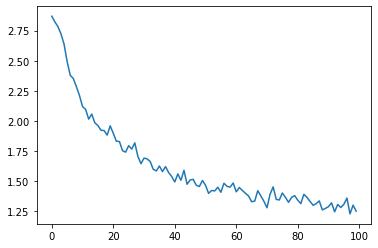

In [13]:
plt.figure()
plt.plot(all_losses)
plt.show()

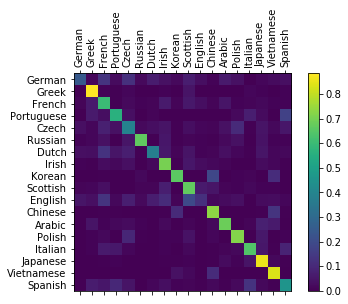

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_Hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [15]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.69) Czech
(-1.01) Russian
(-2.97) English

> Jackson
(-0.72) Scottish
(-1.48) English
(-2.40) Czech

> Satoshi
(-0.49) Japanese
(-2.13) Polish
(-2.37) Arabic
